#### Small codebook to read in the generated or downloaded JSON files from ONCs database and plot

In [10]:
import matplotlib.pyplot as plt
from pathlib import Path
import os
import json
from base64 import b64decode
import numpy as np

#### Read the saved JSON file and extract data information for plotting

In [11]:
from typing import Dict, Any, Union, Optional, List, Tuple

def read_JSON_file(file_path: Union[str, Path], 
                 include_raw: bool = False,
                 trim: bool = True, 
                 channel_points: Dict[int, int] = {1: 2206, 2: 1561}) -> Dict[str, Any]:
    """Reads and parses a .xt file, extracting temperature data and metadata.
    
    This function opens a .xt file (JSON format), extracts temperature data,
    distance information, raw signals, and metadata from the file.
    
    Args:
        file_path: Path to the .xt file as string or Path object
        include_raw: Whether to include raw signal data in the output
        channel_points: Dictionary mapping channel numbers to the number of points
                        to extract for that channel
        
    Returns:
        A dictionary containing:
            temp_data: Temperature data array (in Celsius)
            distance: Distance array (in meters)
            raw_data: Raw signal data (if include_raw is True)
            metadata: Dictionary of metadata from the file
            
    Raises:
        FileNotFoundError: If the specified file does not exist
        json.JSONDecodeError: If the file is not valid JSON
    """
    # Ensure file_path is a Path object
    file_path = Path(file_path) if not isinstance(file_path, Path) else file_path
    
    # Read and parse the JSON data
    with open(file_path, 'r') as f:
        json_data = json.load(f)
        json_data = json_data['Resp'] # nodified for new JSON structure as compared to xt file structure 
    
    out = {}
    # Extract metadata from the JSON file
    metadata = {
        'channel': json_data['processed data'].get('forward channel', 0) + 1,
        'dz': json_data['processed data']['resampled temperature data']['dz'],
        'first_external_point': json_data['processed data']['resampled temperature data']['first external point'],
        'filename': file_path.name,
        'datetime': json_data.get('date time', None),
    }
    metadata['n_external_points'] = channel_points[metadata['channel']]
    metadata['external_length'] = metadata['n_external_points'] * metadata['dz']
    metadata['total_length'] = metadata['external_length'] + metadata['first_external_point'] * metadata['dz']
    out['metadata'] = metadata
    
    
    # Extract temperature data and convert from Kelvin to Celsius
    temp_data = np.frombuffer(
        b64decode(json_data['processed data']['resampled temperature data']['signal']['Data']), 
        dtype='<f4'
    ) - 273.15  # Convert from K to °C
    
    # Calculate the distance array based on first external point
    pt_from = metadata['first_external_point']
    pt_to = pt_from + channel_points[metadata['channel']]
    
    if trim:
        distance = (np.arange(pt_from, pt_to) - pt_from) * metadata['dz']
        out['temp_data'] = temp_data[pt_from:pt_to]
    else:
        distance = np.arange(0, len(temp_data)) * metadata['dz']
        out['temp_data'] = temp_data
        
    out['distance'] = distance
    
    if include_raw:
        # Extract raw data if available
        raw_data: Dict[str, np.ndarray] = {}
        
        # Process forward raw data if present
        if 'resampled forward raw data' in json_data['processed data']:
            raw_fwd = np.frombuffer(
                b64decode(json_data['processed data']['resampled forward raw data']['signal']['Data']), 
                dtype='<f4'
            )
            # Reshape if necessary - typically for multi-channel data
            if len(raw_fwd) > len(temp_data):
                # Determine number of channels from the JSON or use default of 2
                channels = json_data['processed data'].get('number of channels', 2)
                raw_fwd = raw_fwd.reshape(channels, -1)
            raw_data['forward'] = raw_fwd
        
        # Process reverse raw data if present    
        if 'resampled reverse raw data' in json_data['processed data']:
            raw_rev = np.frombuffer(
                b64decode(json_data['processed data']['resampled reverse raw data']['signal']['Data']), 
                dtype='<f4'
            )
            # Reshape if necessary and maintain consistent shape with forward data
            if len(raw_rev) > len(distance) and 'forward' in raw_data:
                raw_rev = raw_rev.reshape(raw_data['forward'].shape[0], -1)
            raw_data['reverse'] = raw_rev
        out['raw_data'] = raw_data    
        
    # Return structured dictionary with all extracted information
    return out

#### Plot the data information

In [12]:
def plot_dts_data(file_data: Dict[str, Any], 
                  include_raw: bool = False, 
                  figsize: Tuple[int, int] = (12, 8),
                  temp_range: Optional[Tuple[float, float]] = None,
                  save_path: Optional[Union[str, Path]] = None) -> None:
    """Creates comprehensive visualization of DTS data.
    
    This function creates publication-quality plots of the DTS temperature
    data, with options to include raw signal data and customize the appearance.
    
    Args:
        file_data: Dictionary containing DTS data as returned by read_xt_file()
        include_raw: Whether to plot raw signal data in addition to temperature
        figsize: Width and height of the figure in inches
        temp_range: Optional temperature range as (min, max) in Celsius
        save_path: Optional path to save the figure
        
    Returns:
        None: The function creates and displays the plot
    """
    # Extract relevant data from the file_data dictionary
    temp_data = file_data['temp_data']
    distance = file_data['distance']
    metadata = file_data['metadata']
    
    # Create figure with appropriate layout based on include_raw
    if include_raw and 'raw_data' in file_data and file_data['raw_data']:
        fig, axs = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': [2, 1]})
        temp_ax, raw_ax = axs
    else:
        fig, temp_ax = plt.subplots(figsize=figsize)
        
    # Plot temperature data
    temp_line = temp_ax.plot(distance, temp_data, 'b-', linewidth=1.5)
    
    # Set title and labels with metadata information
    title = f"DTS Temperature Data - Channel {metadata['channel']}"
    if 'datetime' in metadata and metadata['datetime']:
        title += f" ({metadata['datetime']})"
    
    temp_ax.set_title(title, fontsize=14)
    temp_ax.set_xlabel('Distance (m)', fontsize=12)
    temp_ax.set_ylabel('Temperature (°C)', fontsize=12)
    
    # Add temperature range if specified
    if temp_range:
        temp_ax.set_ylim(temp_range)
    
    # Add grid and metadata annotations
    temp_ax.grid(True, linestyle='--', alpha=0.7)
    
    # Add metadata text box
    metadata_text = (
        f"Channel: {metadata['channel']}\n"
        f"Δz: {metadata['dz']:.4f} m\n"
        f"First external point: {metadata['first_external_point']}\n"
        f"External length: {metadata.get('external_length', distance[-1]):.2f} m\n"
        f"File: {metadata['filename']}"
    )
    
    # Position the text box in the top right corner
    temp_ax.text(0.98, 0.98, metadata_text, transform=temp_ax.transAxes,
                fontsize=10, verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.7))
    
    # Plot raw data if requested and available
    if include_raw and 'raw_data' in file_data and file_data['raw_data']:
        raw_data = file_data['raw_data']
        
        if 'forward' in raw_data:
            # Check dimensionality of raw data
            raw_fwd = raw_data['forward']
            if raw_fwd.ndim > 1:
                # For multi-channel raw data
                for i in range(raw_fwd.shape[0]):
                    # Ensure we have enough data to plot
                    start_idx = metadata['first_external_point']
                    end_idx = start_idx + len(distance)
                    
                    # Check if we have enough data points
                    if end_idx <= raw_fwd.shape[1]:
                        raw_ax.plot(distance, raw_fwd[i, start_idx:end_idx],
                                  label=f'Stokes data {i+1}')
            else:
                # For single-channel raw data
                start_idx = metadata['first_external_point']
                end_idx = start_idx + len(distance)
                
                # Check if we have enough data points
                if end_idx <= len(raw_fwd):
                    raw_ax.plot(distance, raw_fwd[start_idx:end_idx],
                              label='Forward')
                
        if 'reverse' in raw_data:
            raw_rev = raw_data['reverse']
            if raw_rev.ndim > 1:
                # For multi-channel raw data
                for i in range(raw_rev.shape[0]):
                    # Ensure we have enough data to plot
                    start_idx = metadata['first_external_point']
                    end_idx = start_idx + len(distance)
                    
                    # Check if we have enough data points
                    if end_idx <= raw_rev.shape[1]:
                        raw_ax.plot(distance, raw_rev[i, start_idx:end_idx],
                                  label=f'Channel {i+1} (rev)', linestyle='--')
            else:
                # For single-channel raw data
                start_idx = metadata['first_external_point']
                end_idx = start_idx + len(distance)
                
                # Check if we have enough data points
                if end_idx <= len(raw_rev):
                    raw_ax.plot(distance, raw_rev[start_idx:end_idx],
                              label='Reverse', linestyle='--')
        
        raw_ax.set_xlabel('Distance (m)', fontsize=12)
        raw_ax.set_ylabel('Raw Signal', fontsize=12)
        raw_ax.grid(True, linestyle='--', alpha=0.7)
        raw_ax.legend(loc='best')
    
    # Adjust layout for better appearance
    fig.tight_layout()
    
    # Save figure if a path is provided
    if save_path:
        save_path = Path(save_path) if not isinstance(save_path, Path) else save_path
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    # Display the plot
    plt.show()

In [13]:
out = read_JSON_file('./data/realtime/SILIXADTSXT19083_20250730T151645.144Z_chan1.json')

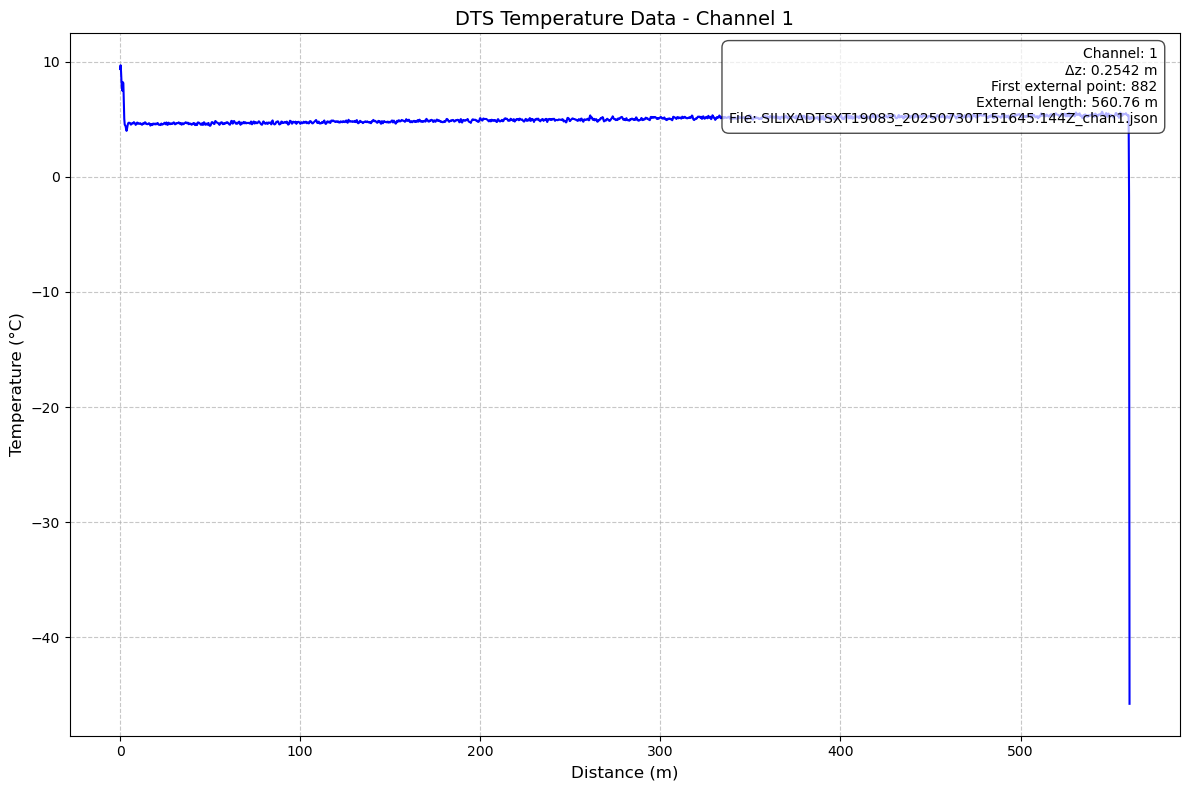

In [14]:
plot_dts_data(out)